# **1. Train/Obtain Models**

In [1]:
import os
import math
import random
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
def get_dataloaders(batch_size=128, num_workers=2):
    transform = transforms.ToTensor()
    train = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader

train_loader, test_loader = get_dataloaders()

100%|██████████| 170M/170M [00:08<00:00, 19.0MB/s]


In [3]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

    def forward(self, x):
        h = self.net(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        h = self.fc(z).view(-1, 256, 4, 4)
        return self.net(h)

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [4]:
class DCGAN_Generator(nn.Module):
    def __init__(self, z_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))

class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [7]:
def train_vae(vae, dataloader, epochs=5, lr=1e-3, beta=1.0):
    vae = vae.to(device)
    opt = torch.optim.Adam(vae.parameters(), lr=lr)
    recon_loss = nn.BCELoss(reduction="sum")

    for epoch in range(epochs):
        total_loss = 0
        for x,_ in tqdm(dataloader, desc=f"VAE Epoch {epoch+1}/{epochs}"):
            x = x.to(device)
            opt.zero_grad()
            x_hat, mu, logvar = vae(x)
            recon = recon_loss(x_hat, x)
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon + beta*kl
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss {total_loss/len(dataloader.dataset):.4f}\n")

    torch.save(vae.state_dict(), '/content/drive/MyDrive/ATML_PA1/vae.pth')


def train_gan(G, D, dataloader, z_dim=128, epochs=5, lr=2e-4):
    G, D = G.to(device), D.to(device)
    optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
    optD = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
    bce = nn.BCELoss()

    for epoch in range(epochs):
        G.train(), D.train()
        total_lossD, total_lossG = 0.0, 0.0

        for x,_ in tqdm(dataloader, desc=f"GAN Epoch {epoch+1}/{epochs}"):
            x = (x*2-1).to(device)  # scale [0,1] -> [-1,1]
            bs = x.size(0)
            real_lbl = torch.ones(bs, device=device)
            fake_lbl = torch.zeros(bs, device=device)

            # ----- Train D -----
            optD.zero_grad()
            d_real = D(x).squeeze()
            lossD_real = bce(d_real, real_lbl)

            z = torch.randn(bs, z_dim, device=device)
            fake = G(z)
            d_fake = D(fake.detach()).squeeze()
            lossD_fake = bce(d_fake, fake_lbl)

            lossD = lossD_real + lossD_fake
            lossD.backward()
            optD.step()

            # ----- Train G -----
            optG.zero_grad()
            d_fake = D(fake).squeeze()
            lossG = bce(d_fake, real_lbl)
            lossG.backward()
            optG.step()

            # Track losses
            total_lossD += lossD.item()
            total_lossG += lossG.item()

        avg_lossD = total_lossD / len(dataloader)
        avg_lossG = total_lossG / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] --- D Loss: {avg_lossD:.4f} --- G Loss: {avg_lossG:.4f}\n")

    torch.save(G.state_dict(), '/content/drive/MyDrive/ATML_PA1/generator.pth')
    torch.save(G.state_dict(), '/content/drive/MyDrive/ATML_PA1/discriminator.pth')


In [8]:
vae = VAE(latent_dim=128)
G = DCGAN_Generator(z_dim=128)
D = DCGAN_Discriminator()

# Train VAE
train_vae(vae, train_loader, epochs=5)   # increase epochs later

print("\n\n\n")

# Train GAN
train_gan(G, D, train_loader, epochs=5)

VAE Epoch 1/5: 100%|██████████| 391/391 [00:10<00:00, 35.98it/s]


Epoch 1, Loss 1888.9649


VAE Epoch 2/5: 100%|██████████| 391/391 [00:08<00:00, 47.02it/s]


Epoch 2, Loss 1837.5371


VAE Epoch 3/5: 100%|██████████| 391/391 [00:09<00:00, 41.86it/s]


Epoch 3, Loss 1830.8272


VAE Epoch 4/5: 100%|██████████| 391/391 [00:09<00:00, 42.53it/s]


Epoch 4, Loss 1827.8928


VAE Epoch 5/5: 100%|██████████| 391/391 [00:07<00:00, 49.84it/s]


Epoch 5, Loss 1826.5063






GAN Epoch 1/5: 100%|██████████| 391/391 [00:12<00:00, 32.39it/s]


Epoch [1/5] --- D Loss: 0.4423 --- G Loss: 4.1345


GAN Epoch 2/5: 100%|██████████| 391/391 [00:11<00:00, 32.68it/s]


Epoch [2/5] --- D Loss: 0.4506 --- G Loss: 3.8083


GAN Epoch 3/5: 100%|██████████| 391/391 [00:12<00:00, 32.48it/s]


Epoch [3/5] --- D Loss: 0.5676 --- G Loss: 3.1244


GAN Epoch 4/5: 100%|██████████| 391/391 [00:12<00:00, 31.92it/s]


Epoch [4/5] --- D Loss: 0.5292 --- G Loss: 2.7395


GAN Epoch 5/5: 100%|██████████| 391/391 [00:12<00:00, 31.91it/s]


Epoch [5/5] --- D Loss: 0.5774 --- G Loss: 2.8719


# **2. Reconstruction vs Generation**

In [44]:
# !pip install torch_fidelity

Original Images:


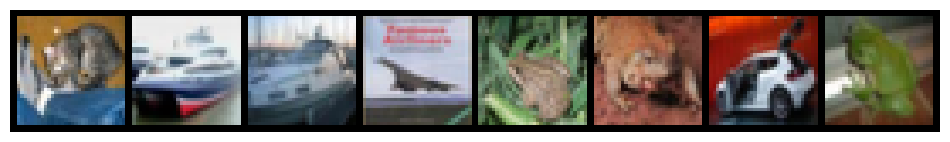

VAE Reconstructions:


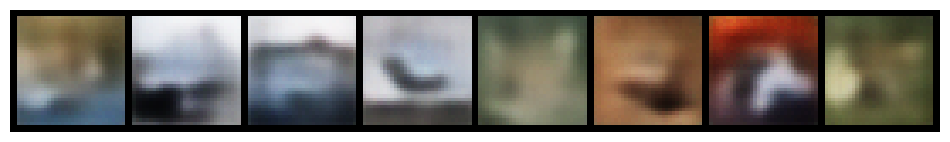

GAN Random Samples:


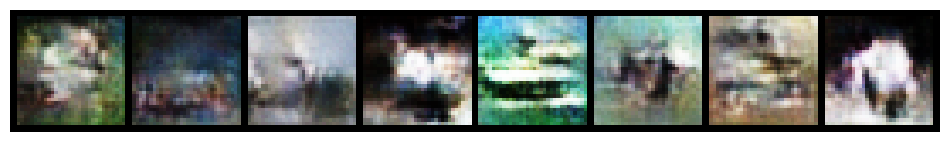

VAE Reconstruction MSE (avg per pixel): 0.012976


In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# ----- Helper: show a grid of images -----
def show_images(images, nrow=8, title=None):
    grid = make_grid(images, nrow=nrow, normalize=True, value_range=(0,1))
    npimg = grid.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(12,6))
    plt.imshow(npimg)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

# ----- Reconstruction vs Generation -----
def compare_reconstruction_vs_generation(vae, G, test_loader, n_samples=8, z_dim=128):
    vae.eval()
    G.eval()

    # --- 1. Pick random test images ---
    x, _ = next(iter(test_loader))
    x = x[:n_samples].to(device)

    # --- 2. VAE reconstruction ---
    with torch.no_grad():
        x_hat, mu, logvar = vae(x)

    # --- 3. GAN random samples ---
    with torch.no_grad():
        z = torch.randn(n_samples, z_dim, device=device)
        gan_samples = G(z)

    # --- 4. Display ---
    print("Original Images:")
    show_images(x, nrow=n_samples)

    print("VAE Reconstructions:")
    show_images(x_hat, nrow=n_samples)

    print("GAN Random Samples:")
    # GAN outputs are in [-1,1] so rescale
    gan_samples = (gan_samples + 1) / 2
    show_images(gan_samples, nrow=n_samples)

    # --- 5. Metrics ---
    mse = torch.mean((x - x_hat) ** 2).item()
    print(f"VAE Reconstruction MSE (avg per pixel): {mse:.6f}")

    # # Optional: compute FID using torch-fidelity if installed
    # try:
    #     from torch_fidelity import calculate_metrics
    #     fid_results = calculate_metrics(
    #         input1=x_hat,  # VAE reconstructions
    #         input2=x,      # Real images
    #         cuda=torch.cuda.is_available(),
    #         isc=False,
    #         fid=True
    #     )
    #     print("FID (VAE reconstructions vs real):", fid_results["frechet_inception_distance"])

    #     fid_results_gan = calculate_metrics(
    #         input1=gan_samples,
    #         input2=x,
    #         cuda=torch.cuda.is_available(),
    #         isc=False,
    #         fid=True
    #     )
    #     print("FID (GAN samples vs real):", fid_results_gan["frechet_inception_distance"])

    # except ImportError:
    #     print("FID not computed (install torch-fidelity with `pip install torch-fidelity`).")


# Example: compare 8 images
compare_reconstruction_vs_generation(vae, G, test_loader, n_samples=8, z_dim=128)


In [12]:
import os
import torchvision.utils as vutils
from torch_fidelity import calculate_metrics

def save_images_to_dir(images, out_dir, prefix="img"):
    os.makedirs(out_dir, exist_ok=True)
    for i, img in enumerate(images):
        vutils.save_image(img, os.path.join(out_dir, f"{prefix}_{i}.png"))

def compute_fid(vae, G, test_loader, n_samples=500, z_dim=128):
    vae.eval()
    G.eval()

    # take test samples
    x, _ = next(iter(test_loader))
    x = x[:n_samples].to(device)

    with torch.no_grad():
        # VAE reconstructions
        x_hat, _, _ = vae(x)
        # GAN samples
        z = torch.randn(n_samples, z_dim, device=device)
        gan_samples = G(z)
        gan_samples = (gan_samples + 1) / 2  # rescale to [0,1]

    # save to temp dirs
    save_images_to_dir(x, "fid_images/real", prefix="real")
    save_images_to_dir(x_hat, "fid_images/vae", prefix="vae")
    save_images_to_dir(gan_samples, "fid_images/gan", prefix="gan")

    # compute FID
    print("Computing FID for VAE reconstructions...")
    fid_vae = calculate_metrics(
        input1="fid_images/vae",
        input2="fid_images/real",
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True
    )

    print("Computing FID for GAN samples...")
    fid_gan = calculate_metrics(
        input1="fid_images/gan",
        input2="fid_images/real",
        cuda=torch.cuda.is_available(),
        isc=False,
        fid=True
    )

    return fid_vae, fid_gan


fid_vae, fid_gan = compute_fid(vae, G, test_loader, n_samples=500, z_dim=128)

Computing FID for VAE reconstructions...


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "fid_images/vae" with extensions png,jpg,jpeg
Found 128 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fid_images/real" with extensions png,jpg,jpeg
Found 128 samples
Processing samples
Frechet Inception Distance: 309.56439020384494
Creating feature extractor "inception-v3-compat" with features ['2048']


Computing FID for GAN samples...


Extracting statistics from input 1
Looking for samples non-recursivelty in "fid_images/gan" with extensions png,jpg,jpeg
Found 500 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "fid_images/real" with extensions png,jpg,jpeg
Found 128 samples
Processing samples
Frechet Inception Distance: 218.428749564506


In [13]:
print("FID (VAE vs Real):", fid_vae["frechet_inception_distance"])
print("FID (GAN vs Real):", fid_gan["frechet_inception_distance"])

FID (VAE vs Real): 309.56439020384494
FID (GAN vs Real): 218.428749564506


# **3. Latent Space Structure**

In [14]:
# Cell A: plotting helpers
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
import math

def show_image_grid(tensor_images, nrow=8, title=None, rescale_from_gan=False):
    """
    tensor_images: (N,C,H,W) in [0,1] for VAE, or [-1,1] for GAN (set rescale_from_gan=True)
    """
    imgs = tensor_images.clone().detach()
    if rescale_from_gan:
        imgs = (imgs + 1.0) / 2.0
        imgs = imgs.clamp(0,1)
    grid = make_grid(imgs.cpu(), nrow=nrow, padding=2, normalize=False)
    npimg = grid.permute(1,2,0).numpy()
    plt.figure(figsize=(min(16, 2*nrow), 2*math.ceil(len(imgs)/nrow)))
    plt.imshow(npimg)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

Original labels: left=0, right=7


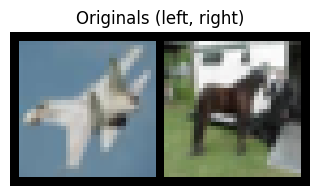

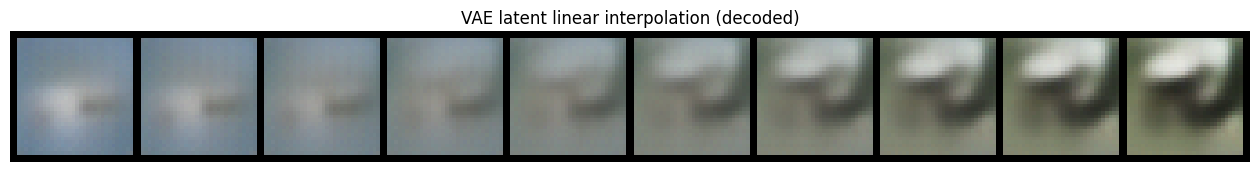

In [18]:
# Cell B: VAE interpolation between two test images (different classes)
def interpolate_images_vae(vae, test_loader, idx1=0, idx2=1, n_steps=10):
    """
    idx1, idx2: indices within a single batch in test_loader iteration (not dataset index).
    n_steps: includes endpoints (e.g., 10 -> 10 images)
    """
    vae.eval()
    with torch.no_grad():
      # fetch one batch
      imgs, labels = next(iter(test_loader))
      imgs = imgs.to(device)
      # select two images (if idx out of range, clamp)
      bsz = imgs.size(0)
      i1 = min(idx1, bsz-1)
      i2 = min(idx2, bsz-1)
      x1 = imgs[i1:i1+1]
      x2 = imgs[i2:i2+1]
      # encode to mu (latent mean)
      mu1, logvar1 = vae.encoder(x1)
      mu2, logvar2 = vae.encoder(x2)
      # linear interpolation in latent space (on mu)
      alphas = torch.linspace(0, 1, n_steps, device=device)
      zs = torch.stack([mu1*(1-a) + mu2*a for a in alphas], dim=0).squeeze(1)  # (n_steps, latent_dim)
      # decode
      decs = vae.decoder(zs)
      # arrange: original1, original2, decoded sequence
      print(f"Original labels: left={int(labels[i1].item())}, right={int(labels[i2].item())}")
      show_image_grid(torch.cat([x1, x2], dim=0), nrow=2, title="Originals (left, right)")
      show_image_grid(decs, nrow=n_steps, title="VAE latent linear interpolation (decoded)")

# Example usage:
interpolate_images_vae(vae, test_loader, idx1=10, idx2=20, n_steps=10)

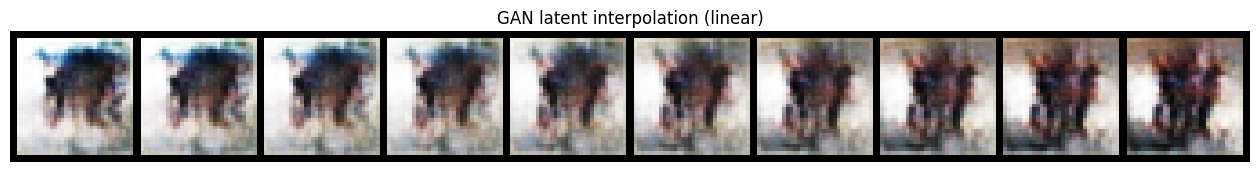

In [22]:
# Cell C: GAN interpolation between two random z vectors
def interpolate_gan_z(G, z_dim=128, n_steps=10, seed=None):
    G.eval()
    with torch.no_grad():
      if seed is not None:
          torch.manual_seed(seed)
      z1 = torch.randn(1, z_dim, device=device)
      z2 = torch.randn(1, z_dim, device=device)
      alphas = torch.linspace(0, 1, n_steps, device=device)
      zs = torch.stack([z1*(1-a) + z2*a for a in alphas], dim=0).squeeze(1)  # (n_steps, z_dim)
      imgs = G(zs)  # (n_steps, 3, H, W) in [-1,1]
      show_image_grid(imgs, nrow=n_steps, title="GAN latent interpolation (linear)", rescale_from_gan=True)

# Example usage:
interpolate_gan_z(G, z_dim=128, n_steps=10, seed=42)

Selected indices in batch: 0 1 labels: 3 8
Original labels: left=3, right=8


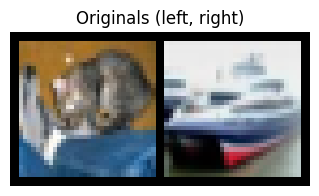

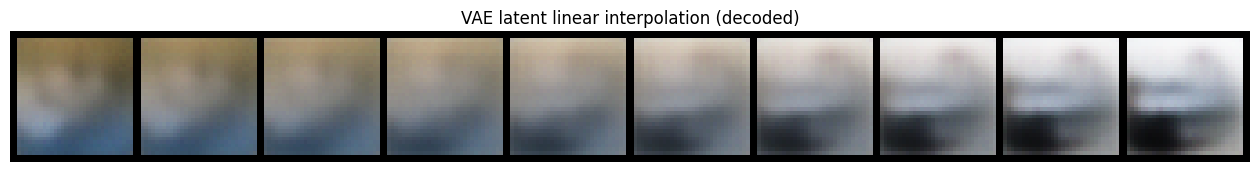

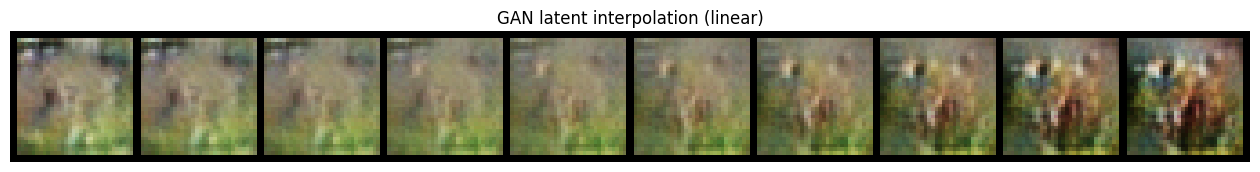

In [23]:
# Cell D: Pick two test images from different classes automatically
def find_two_different_class_indices(batch_labels):
    # returns indices i,j in batch where labels differ (first found)
    labels = batch_labels.numpy()
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if labels[i] != labels[j]:
                return i, j
    return 0, 1

# usage
imgs, labels = next(iter(test_loader))
i1, i2 = find_two_different_class_indices(labels)
print("Selected indices in batch:", i1, i2, "labels:", labels[i1].item(), labels[i2].item())
interpolate_images_vae(vae, test_loader, idx1=i1, idx2=i2, n_steps=10)
interpolate_gan_z(G, z_dim=vae.encoder.fc_mu.out_features if hasattr(vae.encoder, 'fc_mu') else 128, n_steps=10, seed=123)

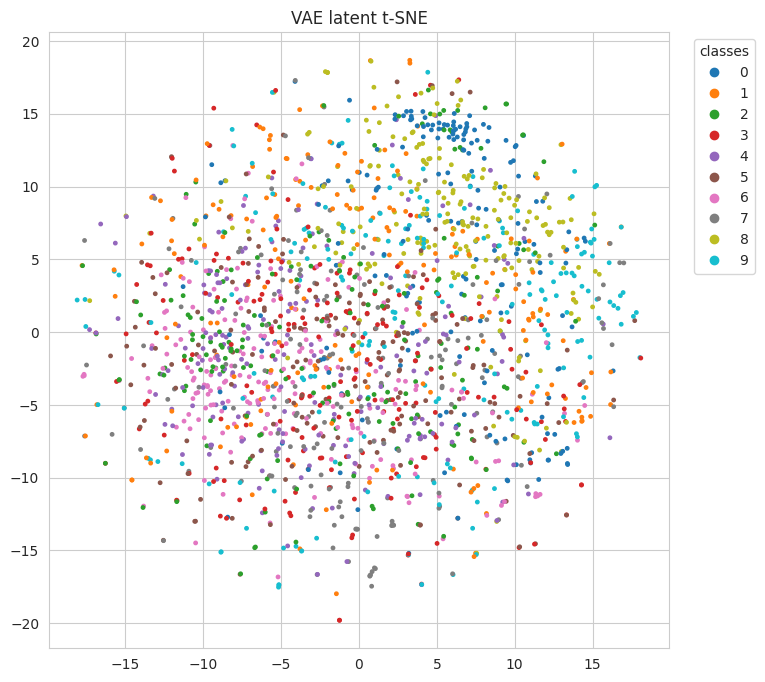

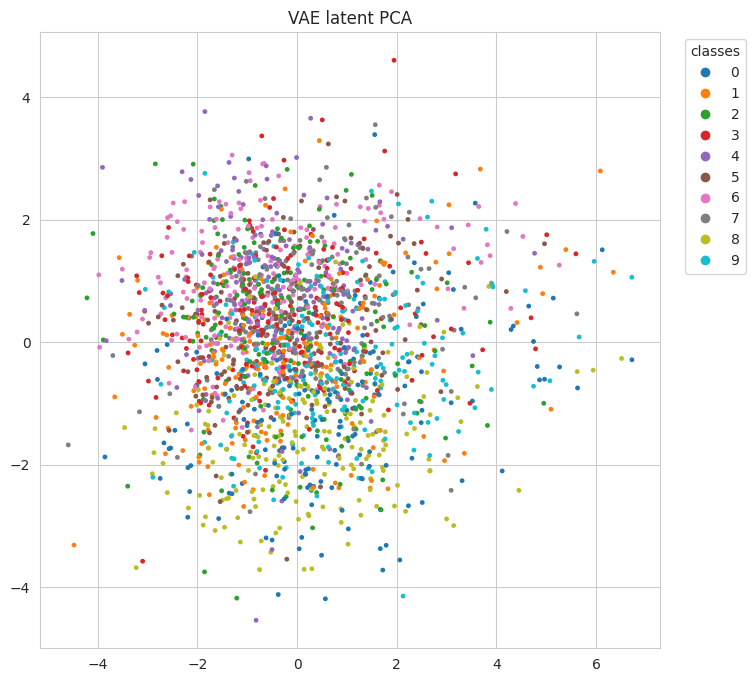

In [25]:
# Cell E: get a lot of VAE latents and run PCA + t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("whitegrid")

@torch.no_grad()
def vae_latent_visualization(vae, loader, n_samples=2000, method='tsne'):
    vae.eval()
    zs = []
    ys = []
    cnt = 0
    for x,y in loader:
        x = x.to(device)
        mu, _ = vae.encoder(x)
        zs.append(mu.cpu().numpy())
        ys.append(y.numpy())
        cnt += x.size(0)
        if cnt >= n_samples:
            break
    zs = np.concatenate(zs, axis=0)[:n_samples]
    ys = np.concatenate(ys, axis=0)[:n_samples]

    if method=='pca':
        proj = PCA(n_components=2).fit_transform(zs)
        title = "VAE latent PCA"
    else:
        proj = TSNE(n_components=2, perplexity=30, init='random').fit_transform(zs)
        title = "VAE latent t-SNE"

    plt.figure(figsize=(8,8))
    scatter = plt.scatter(proj[:,0], proj[:,1], c=ys, cmap='tab10', s=6)
    plt.legend(*scatter.legend_elements(), title="classes", loc='upper right', bbox_to_anchor=(1.15,1))
    plt.title(title)
    plt.show()
    return proj, ys

# Example usage:
proj, ys = vae_latent_visualization(vae, test_loader, n_samples=2000, method='tsne')
proj_pca, ys_pca = vae_latent_visualization(vae, test_loader, n_samples=2000, method='pca')

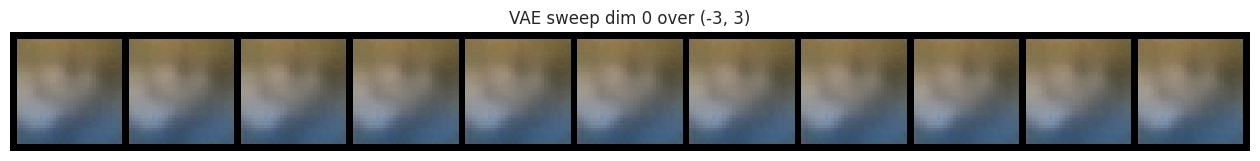

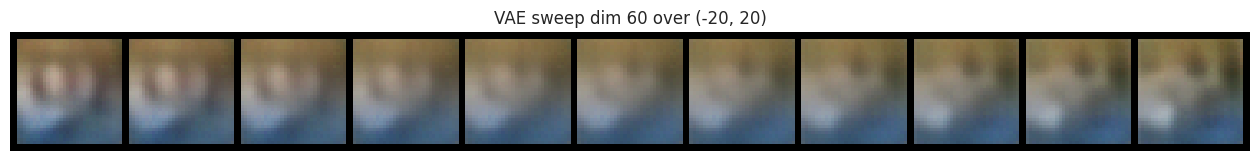

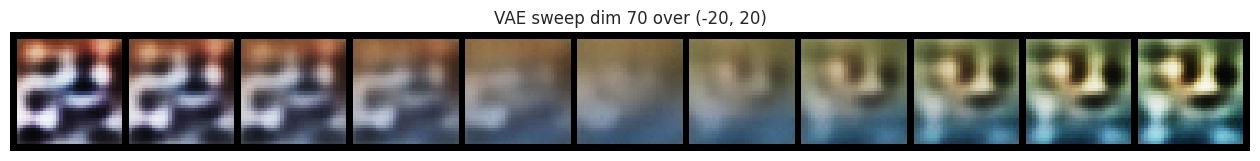

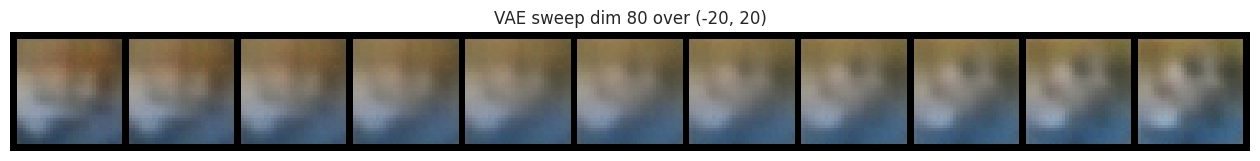

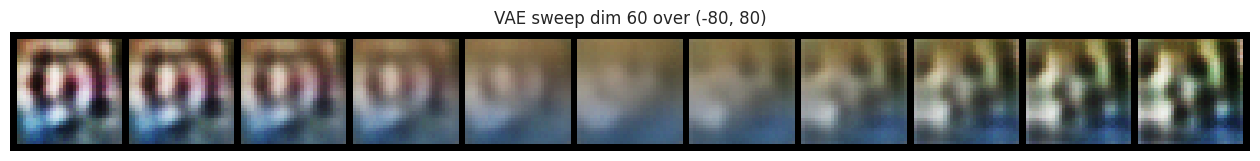

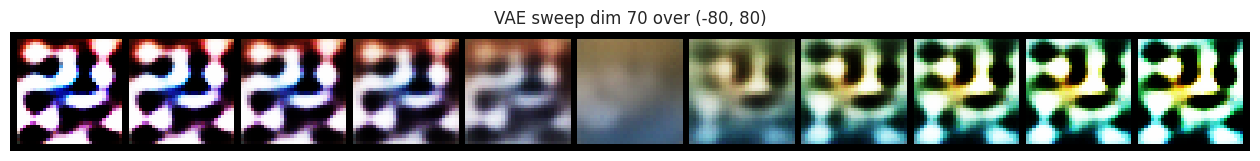

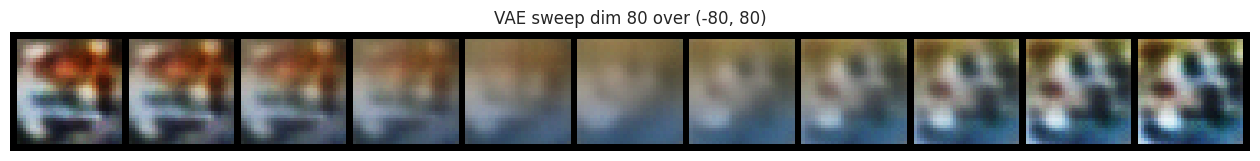

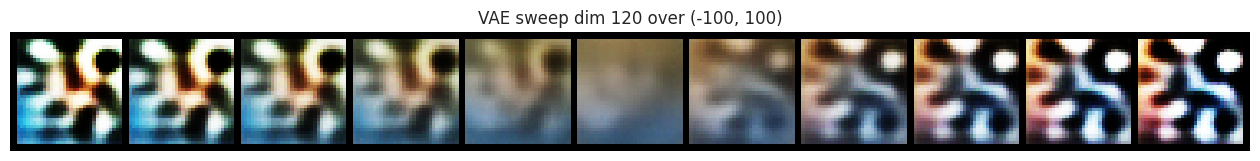

In [32]:
# Cell F: Vary one latent dimension while fixing others for VAE
@torch.no_grad()
def sweep_vae_latent_dimension(vae, base_img=None, dim=0, sweep_range=(-3,3), steps=11):
    """
    base_img: a single image tensor in [0,1] (C,H,W). If None, take first test image.
    dim: latent dimension index to vary
    """
    vae.eval()
    if base_img is None:
        batch, _ = next(iter(test_loader))
        base_img = batch[0:1].to(device)

    mu, logvar = vae.encoder(base_img)
    z = mu.clone()  # use mean as base
    sweep_vals = torch.linspace(sweep_range[0], sweep_range[1], steps, device=device)
    zs = []
    for val in sweep_vals:
        z_i = z.clone()
        z_i[0, dim] = val
        zs.append(z_i)
    zs = torch.cat(zs, dim=0)  # steps x latent_dim
    decs = vae.decoder(zs)
    show_image_grid(decs, nrow=steps, title=f"VAE sweep dim {dim} over {sweep_range}")

# Example usage:
sweep_vae_latent_dimension(vae, dim=0, sweep_range=(-3,3), steps=11)

sweep_vae_latent_dimension(vae, dim=60, sweep_range=(-20,20), steps=11)
sweep_vae_latent_dimension(vae, dim=70, sweep_range=(-20,20), steps=11)
sweep_vae_latent_dimension(vae, dim=80, sweep_range=(-20,20), steps=11)

sweep_vae_latent_dimension(vae, dim=60, sweep_range=(-80,80), steps=11)
sweep_vae_latent_dimension(vae, dim=70, sweep_range=(-80,80), steps=11)
sweep_vae_latent_dimension(vae, dim=80, sweep_range=(-80,80), steps=11)

sweep_vae_latent_dimension(vae, dim=120, sweep_range=(-100,100), steps=11)
# try a few dims like dim=0..5 to find interesting ones

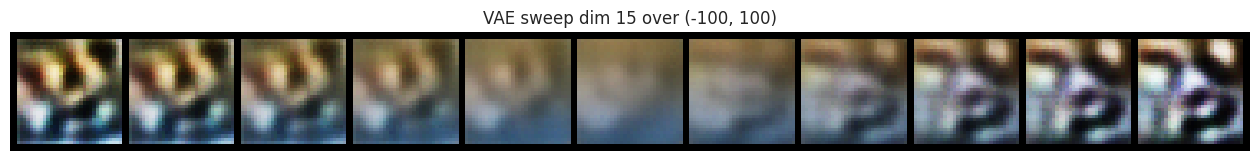

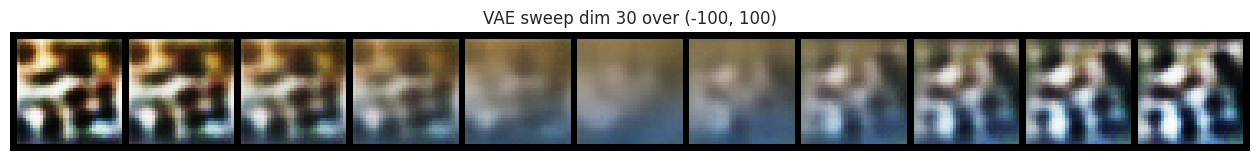

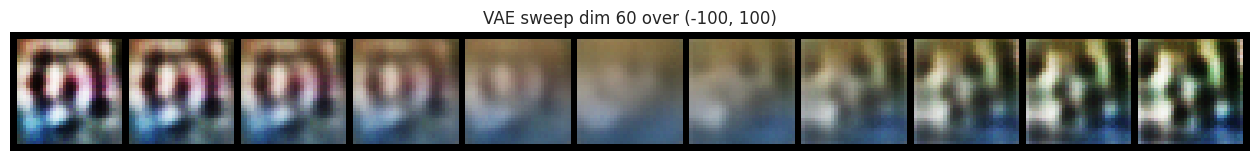

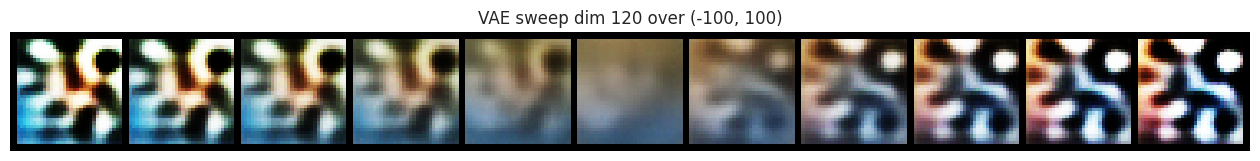

In [36]:
sweep_vae_latent_dimension(vae, dim=15, sweep_range=(-100,100), steps=11)
sweep_vae_latent_dimension(vae, dim=30, sweep_range=(-100,100), steps=11)
sweep_vae_latent_dimension(vae, dim=60, sweep_range=(-100,100), steps=11)
sweep_vae_latent_dimension(vae, dim=120, sweep_range=(-100,100), steps=11)

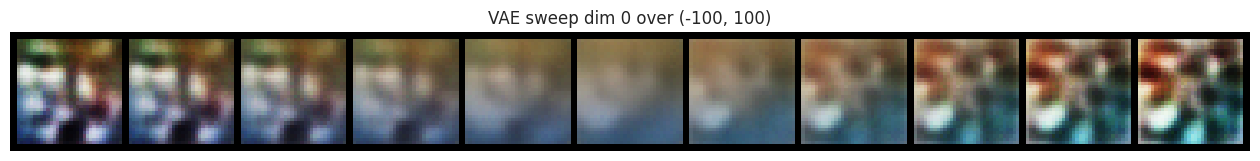

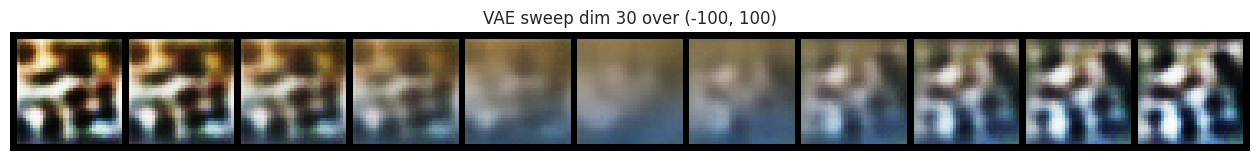

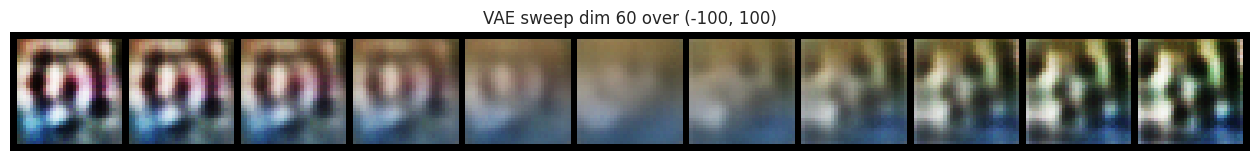

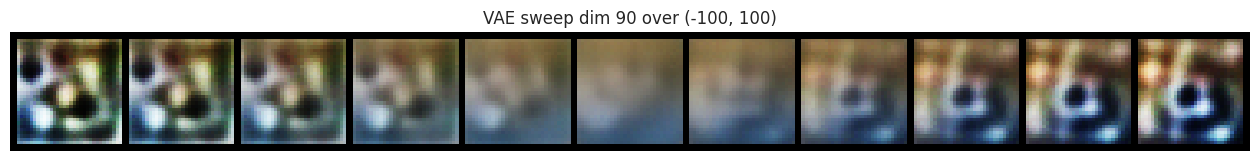

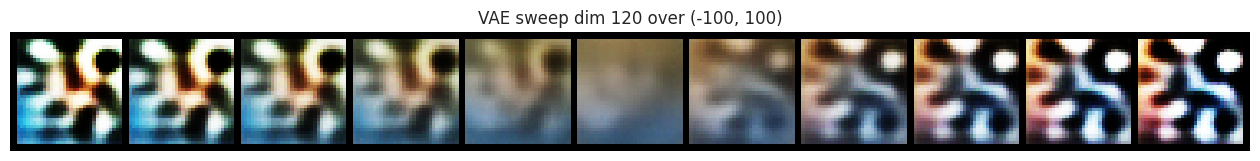

In [37]:
sweep_vae_latent_dimension(vae, dim=0, sweep_range=(-100,100), steps=11)
sweep_vae_latent_dimension(vae, dim=30, sweep_range=(-100,100), steps=11)
sweep_vae_latent_dimension(vae, dim=60, sweep_range=(-100,100), steps=11)
sweep_vae_latent_dimension(vae, dim=90, sweep_range=(-100,100), steps=11)
sweep_vae_latent_dimension(vae, dim=120, sweep_range=(-100,100), steps=11)

GAN PCA component 0


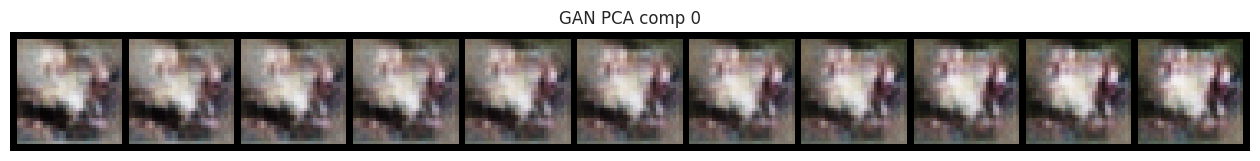

GAN PCA component 1


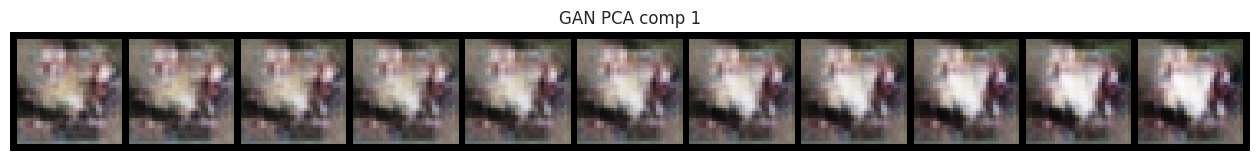

GAN PCA component 2


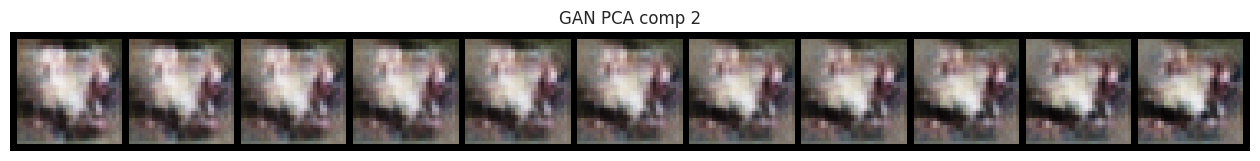

GAN PCA component 3


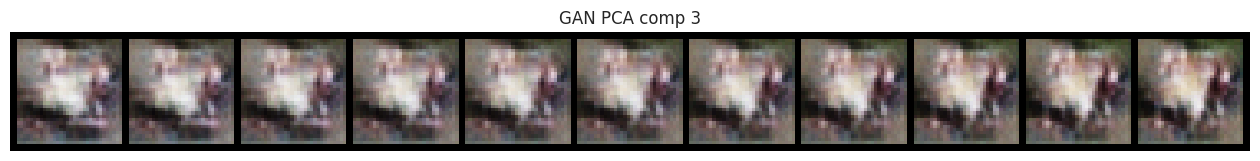

GAN PCA component 0


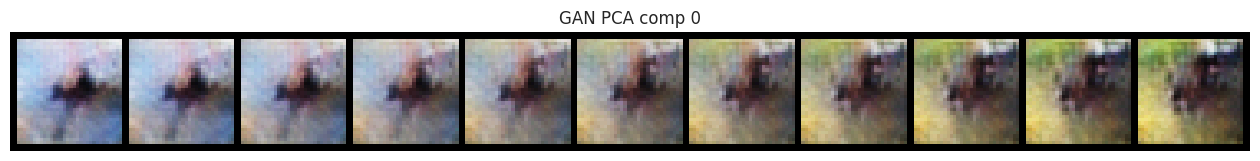

GAN PCA component 1


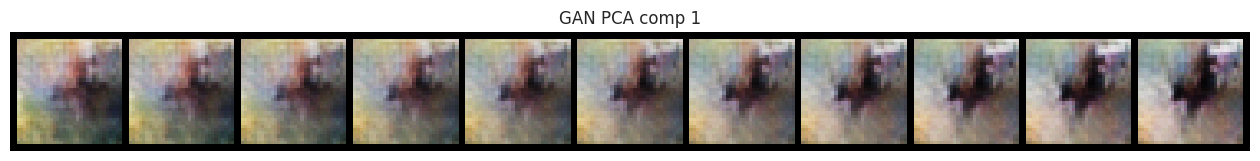

GAN PCA component 2


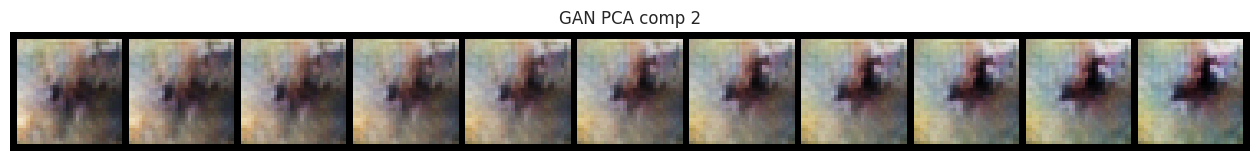

GAN PCA component 3


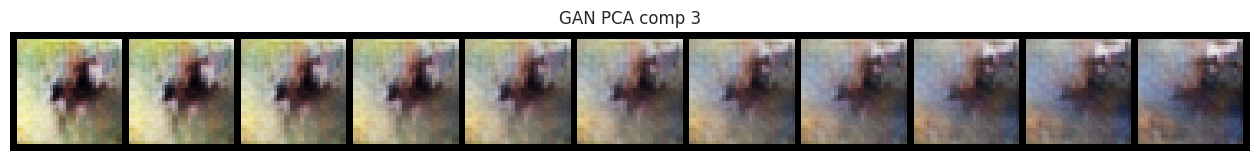

In [34]:
# Cell G: find top PCA directions in many random z's and vary along them (GAN)
@torch.no_grad()
def gan_pca_sweep(G, z_dim=128, n_samples=10000, n_components=6, sweep_scale=3.0, steps=11):
    """
    Generate many random z, compute PCA on them, then vary along principal components for visualization.
    """
    G.eval()
    # draw many z vectors
    zs = []
    batch = 256
    drawn = 0
    while drawn < n_samples:
        to_draw = min(batch, n_samples - drawn)
        z = torch.randn(to_draw, z_dim, device=device)
        zs.append(z.cpu().numpy())
        drawn += to_draw
    zs = np.concatenate(zs, axis=0)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    pca.fit(zs)
    base_z = torch.randn(1, z_dim, device=device)  # start from a random base vector
    comps = pca.components_  # (n_components, z_dim)
    for i in range(n_components):
        direction = torch.tensor(comps[i], dtype=torch.float32, device=device).unsqueeze(0)
        alphas = torch.linspace(-sweep_scale, sweep_scale, steps, device=device)
        zs_sweep = torch.stack([base_z + (a * direction) for a in alphas], dim=0).squeeze(1)
        imgs = G(zs_sweep)
        print(f"GAN PCA component {i}")
        show_image_grid(imgs, nrow=steps, title=f"GAN PCA comp {i}", rescale_from_gan=True)

# Example usage:
gan_pca_sweep(G, z_dim=128, n_samples=2000, n_components=4, sweep_scale=3.0, steps=11)
gan_pca_sweep(G, z_dim=128, n_samples=2000, n_components=4, sweep_scale=5.0, steps=11)

# **4. Out-of-Distribution (OOD) Inputs**

In [38]:
# Cell 1: imports & helpers
import os, math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def show_grid(imgs, title=None, nrow=8, rescale_from_gan=False, figsize=(10,5)):
    imgs = imgs.clone().detach()
    if rescale_from_gan:
        imgs = (imgs + 1.0) / 2.0
        imgs = imgs.clamp(0,1)
    grid = make_grid(imgs.cpu(), nrow=nrow, padding=2)
    npimg = grid.permute(1,2,0).numpy()
    plt.figure(figsize=figsize)
    plt.imshow(npimg)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def save_grid(imgs, out_path, nrow=8, rescale_from_gan=False):
    imgs = imgs.clone().detach()
    if rescale_from_gan:
        imgs = (imgs + 1.0) / 2.0
        imgs = imgs.clamp(0,1)
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    save_image(imgs, out_path, nrow=nrow)

In [39]:
# Cell 2: load OOD datasets
# CIFAR-10 test loader is assumed available as `test_loader`.
# We'll construct CIFAR-100 and SVHN loaders, plus a random-noise generator for synthetic OOD.

batch_size = 128
num_workers = 2

transform = T.Compose([T.ToTensor()])  # images in [0,1]
cifar100_test = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
svhn_test = torchvision.datasets.SVHN(root="./data", split='test', download=True, transform=transform)  # returns (img, label) but labels are ints

c100_loader = DataLoader(cifar100_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
svhn_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Helper to create synthetic geometric shapes or noise
def make_random_noise_batch(n, c=3, h=32, w=32):
    # uniform noise [0,1]
    return torch.rand(n, c, h, w)

def make_random_geometric_batch(n, h=32, w=32):
    # create simple shapes (circles/squares) using numpy and convert to tensor
    import numpy as np
    from PIL import Image, ImageDraw
    imgs = []
    for i in range(n):
        im = Image.new('RGB', (w,h), (0,0,0))
        draw = ImageDraw.Draw(im)
        if np.random.rand() < 0.5:
            # rectangle
            x0 = np.random.randint(0, w//2)
            y0 = np.random.randint(0, h//2)
            x1 = x0 + np.random.randint(w//4, w)
            y1 = y0 + np.random.randint(h//4, h)
            color = tuple((np.random.randint(50,256) for _ in range(3)))
            draw.rectangle([x0,y0,x1,y1], fill=color)
        else:
            # ellipse
            x0 = np.random.randint(0, w//2)
            y0 = np.random.randint(0, h//2)
            x1 = x0 + np.random.randint(w//4, w)
            y1 = y0 + np.random.randint(h//4, h)
            color = tuple((np.random.randint(50,256) for _ in range(3)))
            draw.ellipse([x0,y0,x1,y1], fill=color)
        imgs.append(T.ToTensor()(im))
    return torch.stack(imgs, dim=0)

print("Datasets ready: CIFAR-100, SVHN, synthetic noise/geometric")

100%|██████████| 169M/169M [00:04<00:00, 40.0MB/s]
100%|██████████| 64.3M/64.3M [00:01<00:00, 51.0MB/s]


Datasets ready: CIFAR-100, SVHN, synthetic noise/geometric


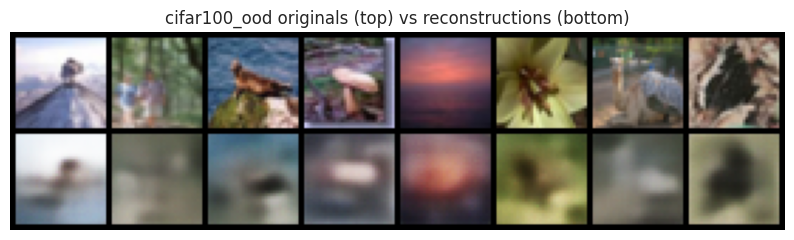

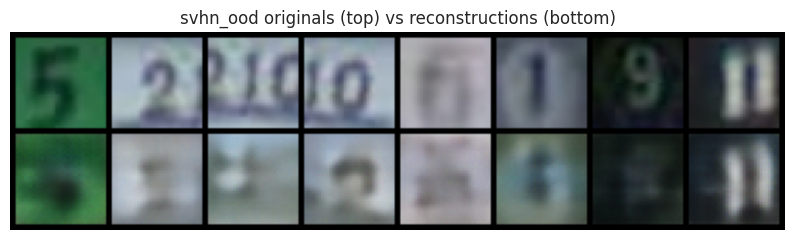

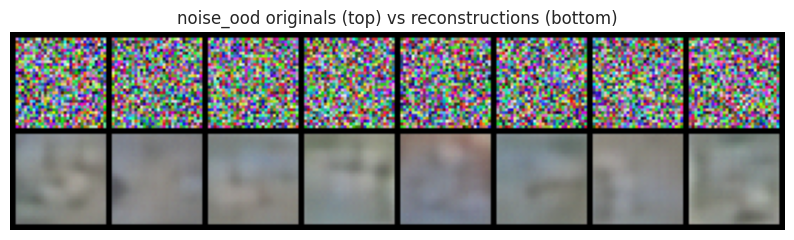

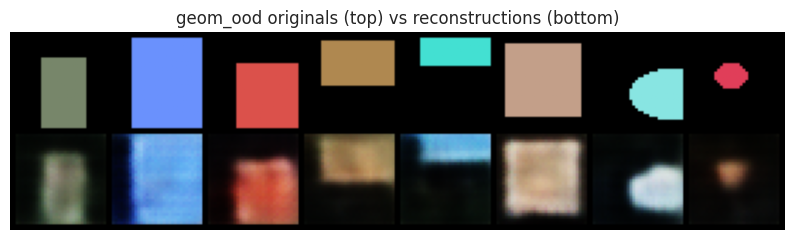

Sample MSEs (first few) -- CIFAR100: [0.00858506 0.00913954 0.01431685 0.01533648 0.00381229] SVHN: [0.00355682 0.00376207 0.00904437 0.00753513 0.0027213 ] Noise: [0.08744037 0.08499234 0.08451477 0.08594209 0.0838983 ] Geom: [0.00854407 0.01107501 0.0103238  0.0094941  0.01112356]


In [40]:
# Cell 3: show examples (orig vs recon) for different OOD sources
vae.eval()
n_show = 8

def vae_recon_grid_for_batch(x_batch, prefix="ood"):
    x_batch = x_batch[:n_show].to(device)
    with torch.no_grad():
        x_hat, _, _ = vae(x_batch)
    # show side-by-side: original then reconstruction
    combined = torch.cat([x_batch.cpu(), x_hat.cpu()], dim=0)  # first half originals, second half recon
    show_grid(combined, title=prefix + " originals (top) vs reconstructions (bottom)", nrow=n_show, rescale_from_gan=False)
    save_grid(combined, out_path=f"samples/{prefix}_vae_recon.png", nrow=n_show, rescale_from_gan=False)
    # return MSE per image
    mse_per_img = ((x_batch - x_hat.to(device))**2).mean(dim=[1,2,3]).cpu().numpy()
    return mse_per_img

# CIFAR-100 (OOD)
x_c100, _ = next(iter(c100_loader))
mse_c100 = vae_recon_grid_for_batch(x_c100, prefix="cifar100_ood")

# SVHN (OOD)
x_svhn, _ = next(iter(svhn_loader))
mse_svhn = vae_recon_grid_for_batch(x_svhn, prefix="svhn_ood")

# Random noise (OOD)
x_noise = make_random_noise_batch(n_show)
mse_noise = vae_recon_grid_for_batch(x_noise, prefix="noise_ood")

# Geometric shapes (OOD)
x_geom = make_random_geometric_batch(n_show)
mse_geom = vae_recon_grid_for_batch(x_geom, prefix="geom_ood")

print("Sample MSEs (first few) -- CIFAR100:", mse_c100[:5], "SVHN:", mse_svhn[:5], "Noise:", mse_noise[:5], "Geom:", mse_geom[:5])

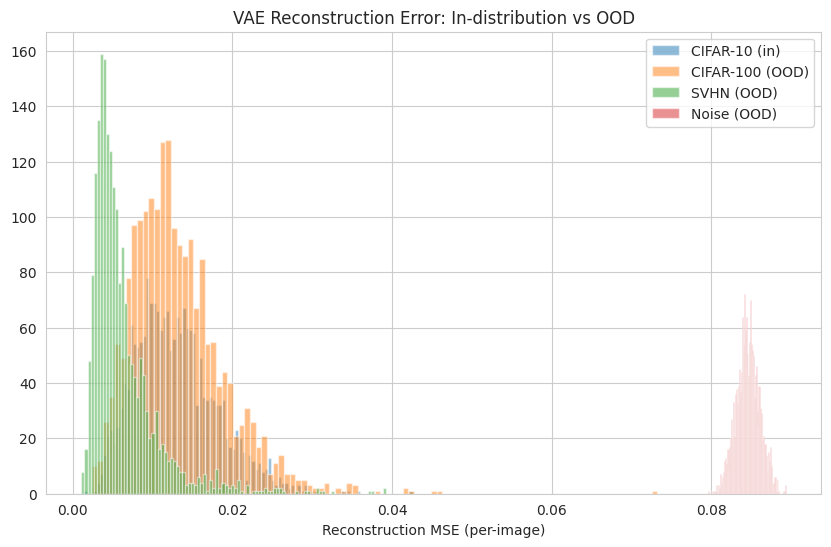

ROC AUC (CIFAR-10 vs CIFAR-100) using VAE reconstruction MSE: 0.5013
ROC AUC (CIFAR-10 vs SVHN) using VAE reconstruction MSE: 0.1242
ROC AUC (CIFAR-10 vs Random-Noise) using VAE reconstruction MSE: 1.0000


In [41]:
# Cell 4: compute distributions and ROC AUC using reconstruction MSE
vae.eval()
def compute_mse_for_loader(loader, n_samples=1000):
    mses = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            x_hat, _, _ = vae(x)
            mse_per = ((x - x_hat)**2).mean(dim=[1,2,3]).cpu().numpy()
            mses.append(mse_per)
            if sum(len(arr) for arr in mses) >= n_samples:
                break
    mses = np.concatenate(mses, axis=0)[:n_samples]
    return mses

# get MSE for CIFAR-10 test (in distribution)
mses_c10 = compute_mse_for_loader(test_loader, n_samples=2000)
# get MSE for CIFAR-100 (OOD)
mses_c100 = compute_mse_for_loader(c100_loader, n_samples=2000)
# get MSE for SVHN (OOD) -- SVHN loader returns (img, label)
mses_svhn = compute_mse_for_loader(svhn_loader, n_samples=2000)

# Also compute for random noise and geometric synthetic OOD (generate on the fly)
def compute_mse_for_synthetic(make_batch_fn, n_samples=2000, batch_size=128):
    mses = []
    with torch.no_grad():
        drawn = 0
        while drawn < n_samples:
            to_draw = min(batch_size, n_samples - drawn)
            x = make_batch_fn(to_draw).to(device)
            x_hat, _, _ = vae(x)
            mse_per = ((x - x_hat)**2).mean(dim=[1,2,3]).cpu().numpy()
            mses.append(mse_per)
            drawn += to_draw
    return np.concatenate(mses, axis=0)[:n_samples]

mses_noise = compute_mse_for_synthetic(lambda n: make_random_noise_batch(n), n_samples=2000)
mses_geom = compute_mse_for_synthetic(lambda n: make_random_geometric_batch(n), n_samples=2000)

# Plot histograms
plt.figure(figsize=(10,6))
plt.hist(mses_c10, bins=100, alpha=0.5, label='CIFAR-10 (in)')
plt.hist(mses_c100, bins=100, alpha=0.5, label='CIFAR-100 (OOD)')
plt.hist(mses_svhn, bins=100, alpha=0.5, label='SVHN (OOD)')
plt.hist(mses_noise, bins=100, alpha=0.5, label='Noise (OOD)')
plt.legend()
plt.xlabel("Reconstruction MSE (per-image)")
plt.title("VAE Reconstruction Error: In-distribution vs OOD")
plt.show()

# ROC AUC: try to distinguish CIFAR-10 (label 0) vs CIFAR-100 (label 1) using MSE (higher -> OOD)
y_true = np.concatenate([np.zeros_like(mses_c10), np.ones_like(mses_c100)])
scores = np.concatenate([mses_c10, mses_c100])  # higher -> more likely OOD
auc_c100 = roc_auc_score(y_true, scores)
print(f"ROC AUC (CIFAR-10 vs CIFAR-100) using VAE reconstruction MSE: {auc_c100:.4f}")

# CIFAR-10 vs SVHN
y_true = np.concatenate([np.zeros_like(mses_c10), np.ones_like(mses_svhn)])
scores = np.concatenate([mses_c10, mses_svhn])
auc_svhn = roc_auc_score(y_true, scores)
print(f"ROC AUC (CIFAR-10 vs SVHN) using VAE reconstruction MSE: {auc_svhn:.4f}")

# CIFAR-10 vs Noise
y_true = np.concatenate([np.zeros_like(mses_c10), np.ones_like(mses_noise)])
scores = np.concatenate([mses_c10, mses_noise])
auc_noise = roc_auc_score(y_true, scores)
print(f"ROC AUC (CIFAR-10 vs Random-Noise) using VAE reconstruction MSE: {auc_noise:.4f}")

Sigma=1.0: show images (GAN outputs for scaled z)


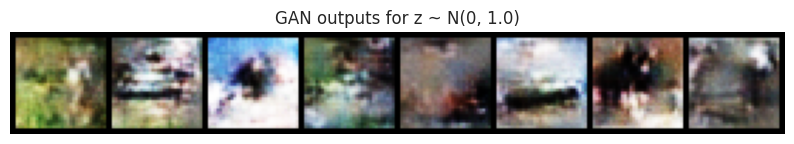

Sigma=2.0: show images (GAN outputs for scaled z)


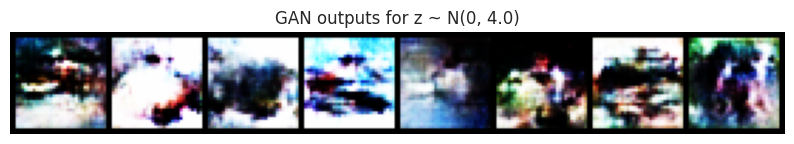

Sigma=4.0: show images (GAN outputs for scaled z)


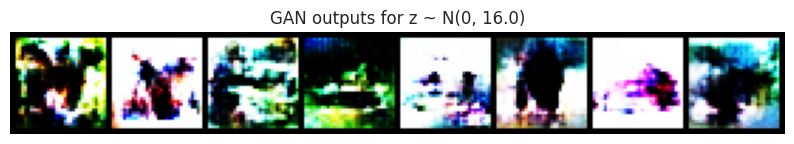

Sigma=8.0: show images (GAN outputs for scaled z)


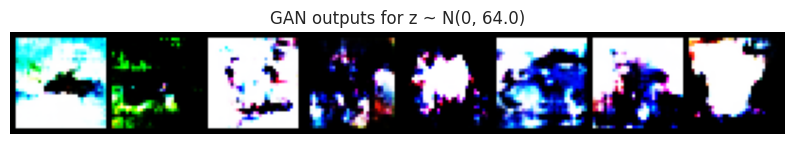

Sigma=16.0: show images (GAN outputs for scaled z)


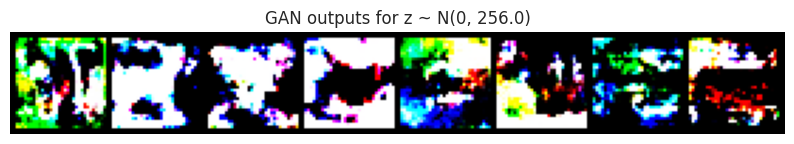

In [42]:
# Cell 5: GAN stress test: sample z ~ N(0, sigma^2 I) for various sigma and visualize
G.eval()
z_dim = vae.encoder.fc_mu.out_features if hasattr(vae.encoder, 'fc_mu') else 128
sigmas = [1.0, 2.0, 4.0, 8.0, 16.0]  # increasing scale
n_per_sigma = 8

for sigma in sigmas:
    zs = torch.randn(n_per_sigma, z_dim, device=device) * sigma
    with torch.no_grad():
        imgs = G(zs)
    print(f"Sigma={sigma}: show images (GAN outputs for scaled z)")
    show_grid(imgs, title=f"GAN outputs for z ~ N(0, {sigma**2})", nrow=n_per_sigma, rescale_from_gan=True)
    save_grid(imgs, out_path=f"samples/gan_sigma_{sigma}.png", nrow=n_per_sigma, rescale_from_gan=True)

Constant z = 5.0


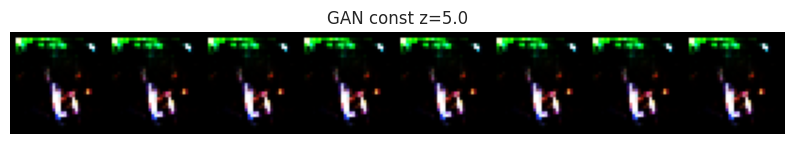

Constant z = 10.0


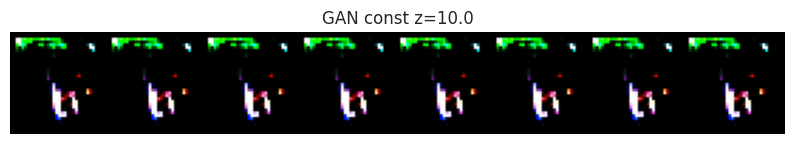

Constant z = 20.0


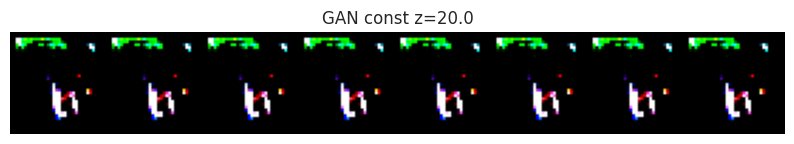

Constant z = 50.0


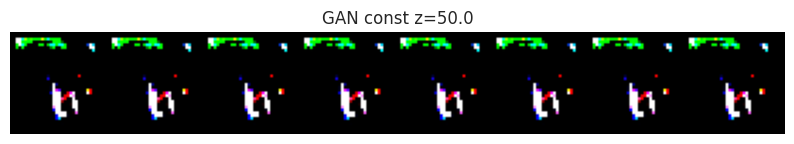

One-hot large dim 0


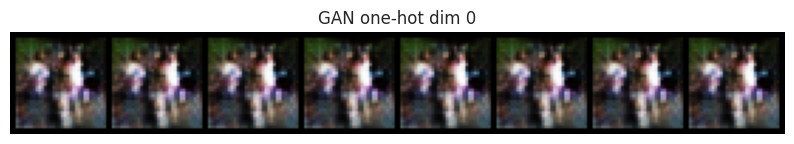

One-hot large dim 1


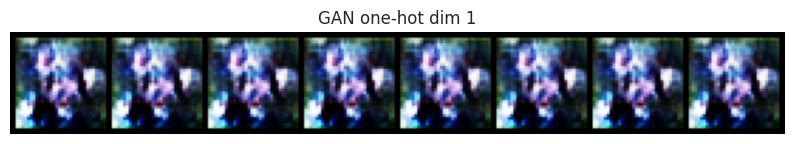

One-hot large dim 2


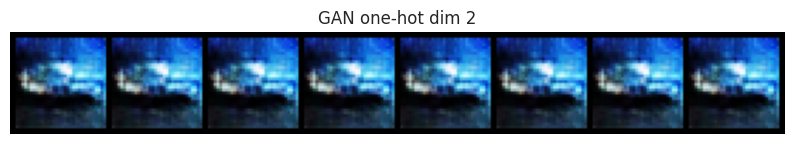

One-hot large dim 3


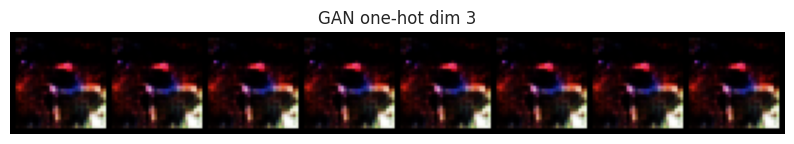

One-hot large dim 4


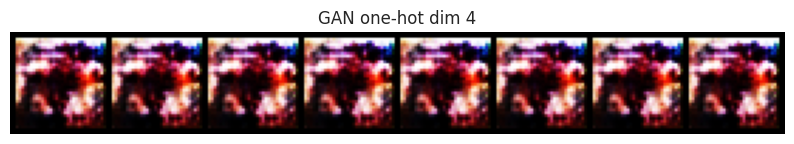

One-hot large dim 5


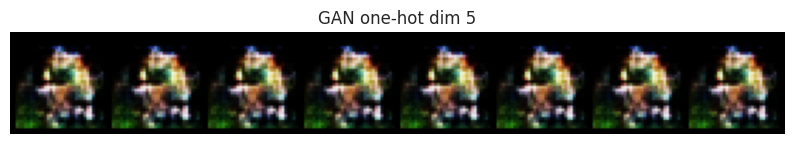

In [43]:
# Cell 6: GAN extreme vectors test: constant very large z and one-hot large components
G.eval()
def test_extreme_vectors(G, z_dim, n=8):
    # constant vector tests
    const_values = [5.0, 10.0, 20.0, 50.0]
    for val in const_values:
        z = torch.ones(n, z_dim, device=device) * val
        with torch.no_grad():
            imgs = G(z)
        print(f"Constant z = {val}")
        show_grid(imgs, title=f"GAN const z={val}", nrow=n, rescale_from_gan=True)
        save_grid(imgs, out_path=f"samples/gan_const_{val}.png", nrow=n, rescale_from_gan=True)

    # one-hot large dims
    for dim_idx in range(min(6, z_dim)):
        z = torch.zeros(n, z_dim, device=device)
        z[:, dim_idx] = 20.0  # large activation in one dimension
        with torch.no_grad():
            imgs = G(z)
        print(f"One-hot large dim {dim_idx}")
        show_grid(imgs, title=f"GAN one-hot dim {dim_idx}", nrow=n, rescale_from_gan=True)
        save_grid(imgs, out_path=f"samples/gan_onehot_dim{dim_idx}.png", nrow=n, rescale_from_gan=True)

test_extreme_vectors(G, z_dim, n=8)